<a href="https://colab.research.google.com/github/13RENDA/GE-Vernova-Capstone/blob/main/Data_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Visualization - Box Plots

#### Author: Sreeram

This section makes the box plots of different columns with power outage percentage in order to find out the outliers.

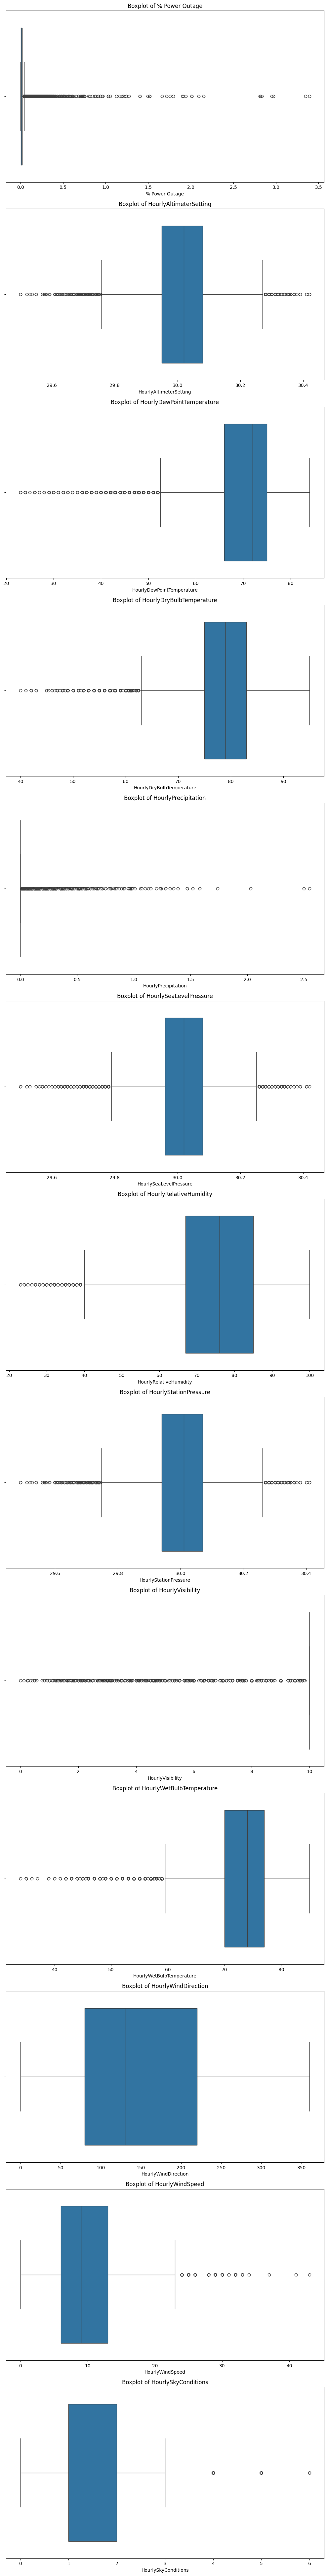

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_visualize = [
    '% Power Outage',
    'HourlyAltimeterSetting',
    'HourlyDewPointTemperature',
    'HourlyDryBulbTemperature',
    'HourlyPrecipitation',
    'HourlySeaLevelPressure',
    'HourlyRelativeHumidity',
    'HourlyStationPressure',
    'HourlyVisibility',
    'HourlyWetBulbTemperature',
    'HourlyWindDirection',
    'HourlyWindSpeed',
    'HourlySkyConditions'
]


fig, axs = plt.subplots(len(columns_to_visualize), 1, figsize=(10, 6*len(columns_to_visualize)))

for i, column in enumerate(columns_to_visualize):
    sns.boxplot(x=df[column], ax=axs[i])
    axs[i].set_title(f'Boxplot of {column}')
    axs[i].set_xlabel(column)

plt.tight_layout()
plt.show()


Median value: 0.008849886455984494


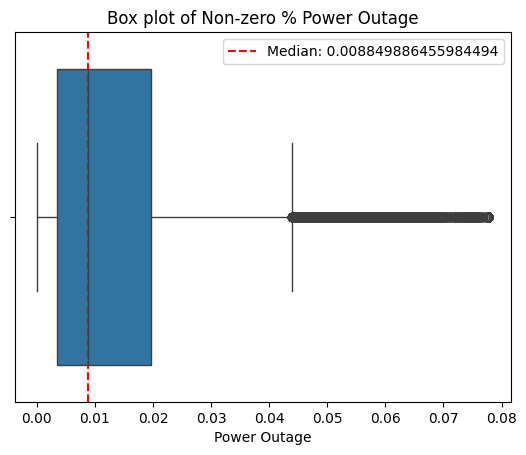

In [ ]:
non_zero_power_outage = df[df['% Power Outage'] != 0]

# Create a box plot using Seaborn
sns.boxplot(x=non_zero_power_outage['% Power Outage'])
plt.xlabel('Power Outage')
plt.title('Box plot of Non-zero % Power Outage')

median_value = non_zero_power_outage['% Power Outage'].median()
plt.axvline(x=median_value, color='r', linestyle='--', label=f'Median: {median_value}')
plt.legend()
print("Median value:", median_value)

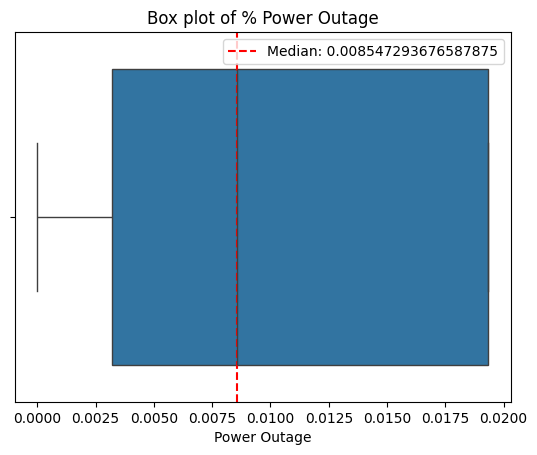

In [ ]:
percentile_95 = df['% Power Outage'].quantile(0.95)

# Replace outliers with the 95th percentile
df.loc[df['% Power Outage'] > percentile_95, '% Power Outage'] = percentile_95

sns.boxplot(x=df['% Power Outage'])
plt.xlabel('Power Outage')
plt.title('Box plot of % Power Outage')

# Calculate and mark the median
median_value = df['% Power Outage'].median()
plt.axvline(x=median_value, color='r', linestyle='--', label=f'Median: {median_value}')
plt.legend()

plt.show()

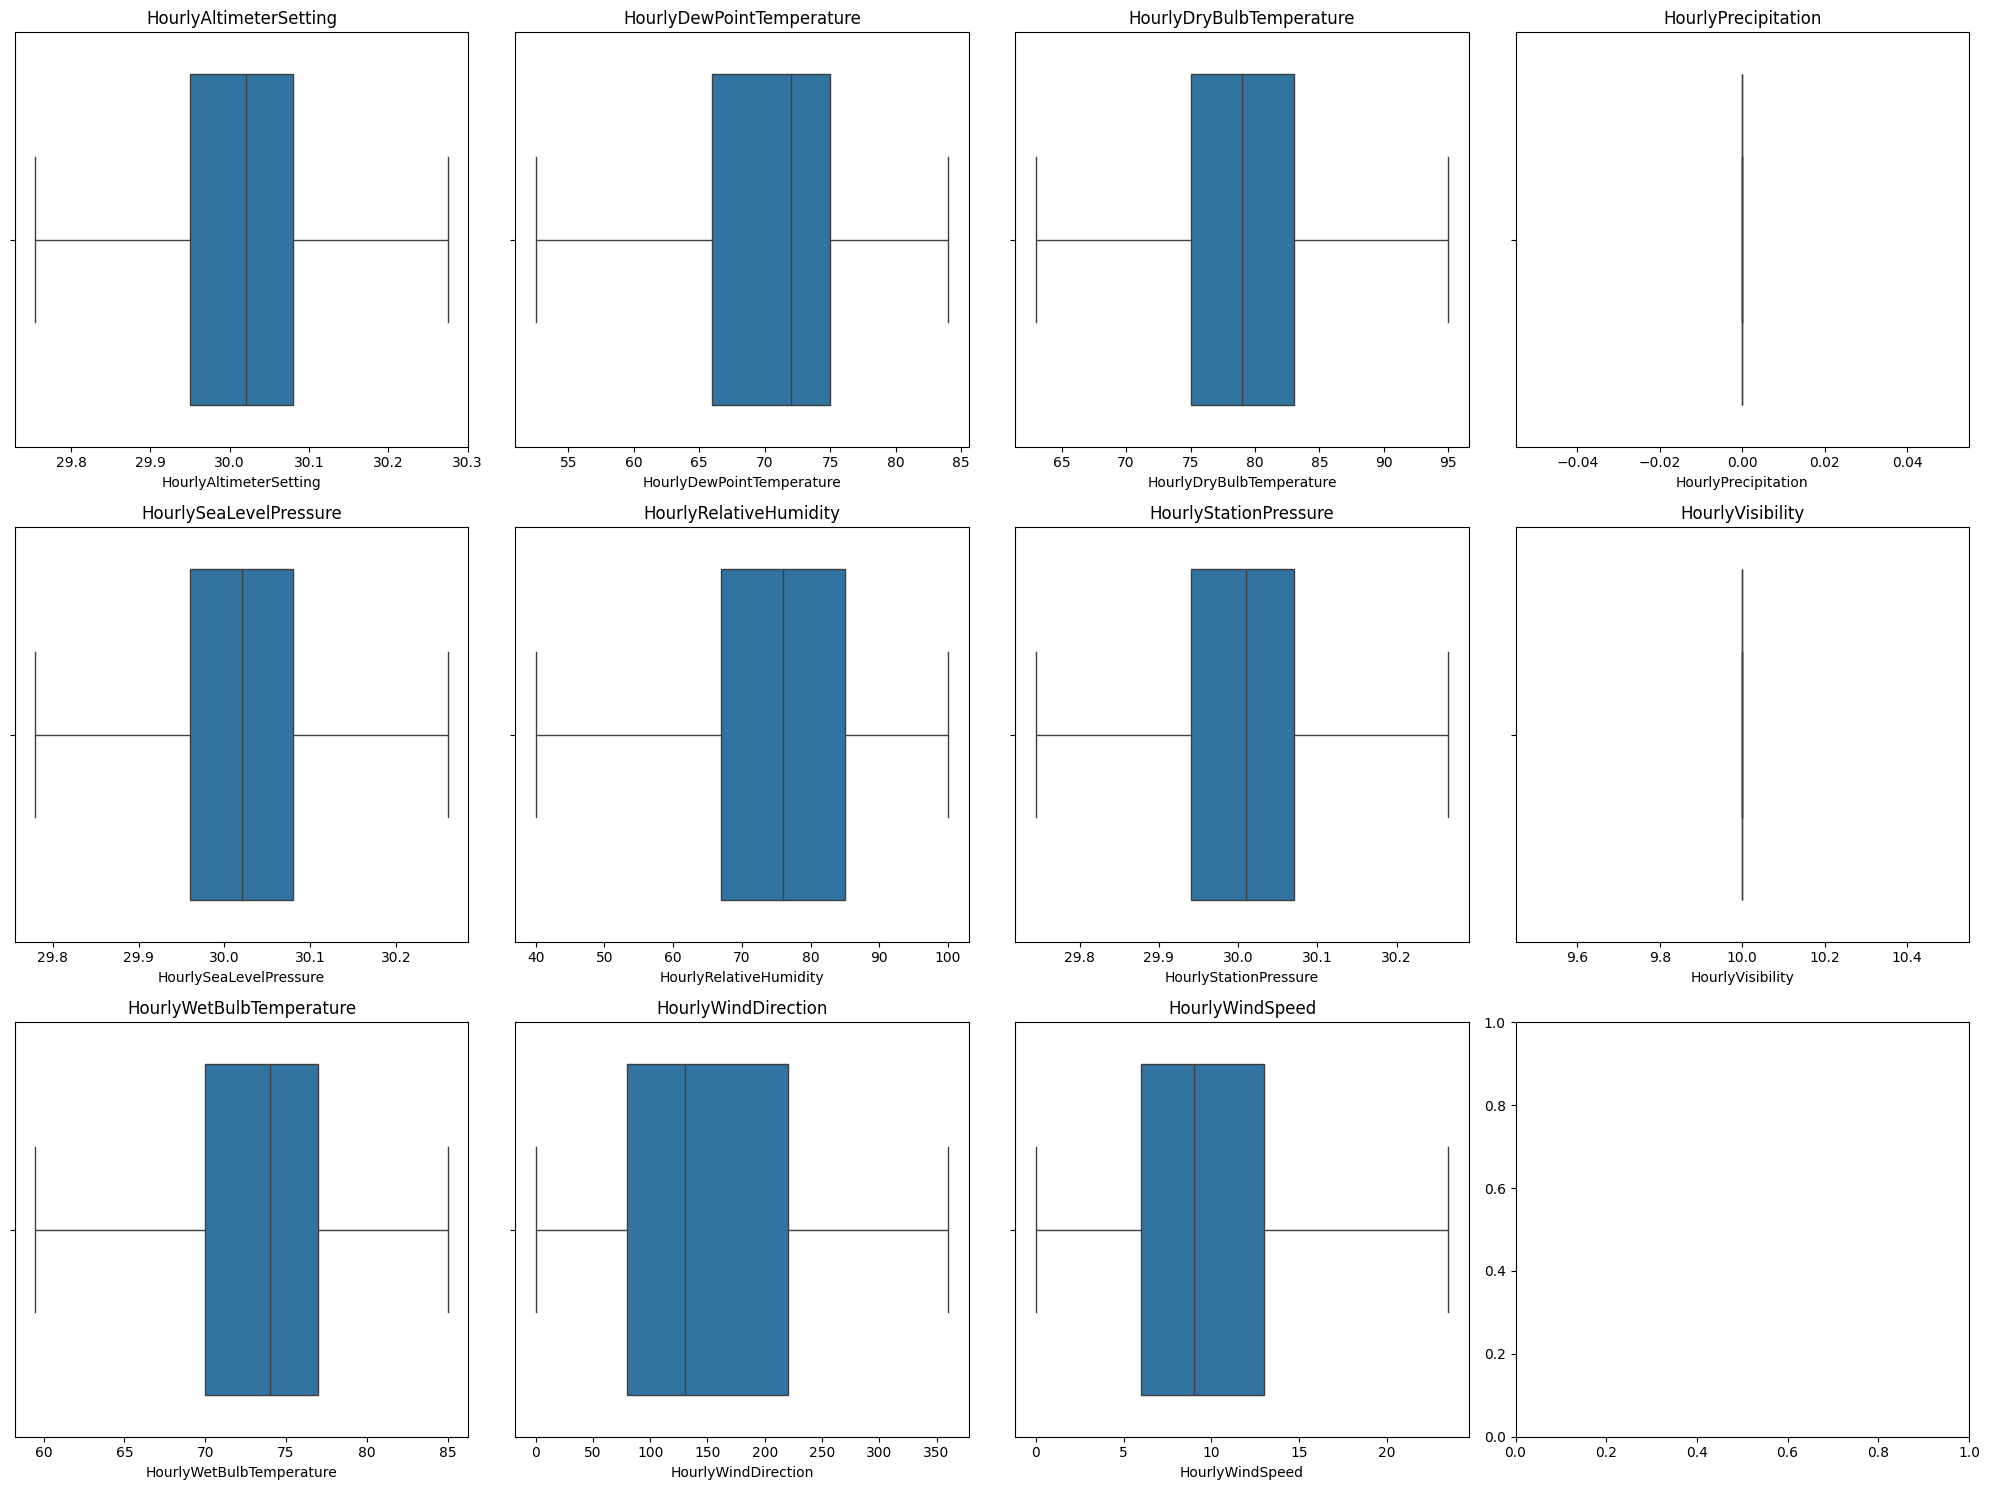

In [ ]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    series_capped = series.apply(lambda x: min(max(x, lower_bound), upper_bound))
    return series_capped

columns_to_adjust = ['HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
                     'HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyRelativeHumidity',
                     'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature',
                     'HourlyWindDirection', 'HourlyWindSpeed']

for column in columns_to_adjust:
    df[column] = cap_outliers(df[column])

import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()
for i, column in enumerate(columns_to_adjust):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()
plt.show()

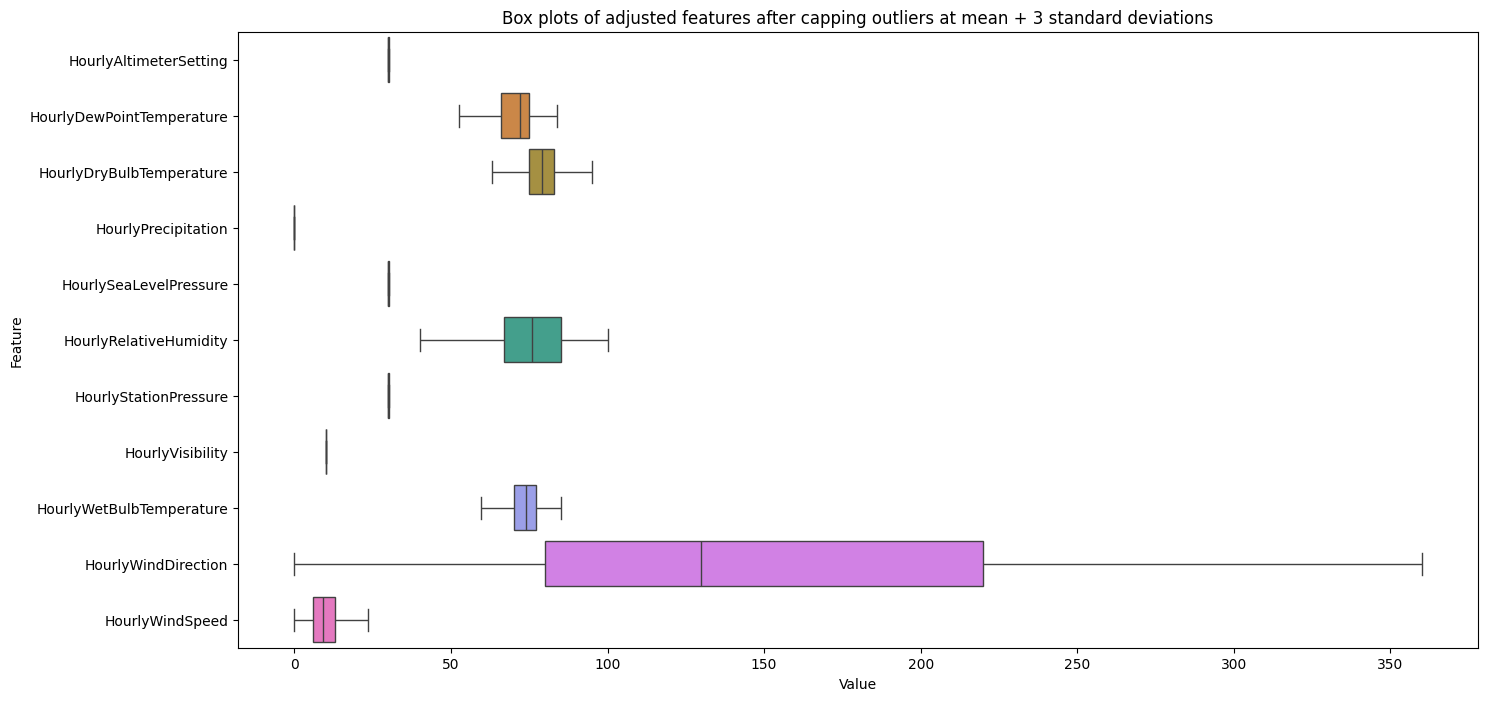

In [ ]:
# Mean + 3std
df1 = df
def cap_outliers(series):
    mean = series.mean()
    std_dev = series.std()
    upper_bound = mean + 3 * std_dev
    series_capped = series.apply(lambda x: min(x, upper_bound))
    return series_capped

for column in columns_to_adjust:
    df1[column] = cap_outliers(df1[column])

plt.figure(figsize=(16, 8))
sns.boxplot(data=df1[columns_to_adjust], orient='h')
plt.title('Box plots of adjusted features after capping outliers at mean + 3 standard deviations')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.show()

## Clean Outliers
#### Author: Kyle

This section clean the outliers in Broward data


In [ ]:
# *Import file
Q1 = df_set['% Power Outage'].quantile(0.25)
Q3 = df_set['% Power Outage'].quantile(0.75)
IQR = Q3 - Q1
df_set = df_set[~((df_set['% Power Outage'] < (Q1 - 1.5 * IQR)) | (df_set['% Power Outage'] > (Q3 + 1.5 * IQR)))]

## Clean Outliers
#### Author: Louis

#### Z-score

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from google.colab import files

uploaded = files.upload() # Orange 2.16 (2).xlsx

for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    csv_path = '/content/' + filename

# Read the uploaded CSV file into a Pandas DataFrame
# Orange
Orange = pd.read_excel(csv_path)
print(Orange['% Power Outage'].count())
# Miami
Miami = pd.read_excel(csv_path)
print(Miami['% Power Outage'].count())
# Broward
Broward = pd.read_excel(csv_path)
print(Broward['% Power Outage'].count())
# PalmBeach
PalmBeach = pd.read_excel(csv_path)
print(PalmBeach['% Power Outage'].count())


In [ ]:
def remove_outliers_zscore_column(county, percent_outage, threshold=3):
    """
    Remove outliers above a certain threshold of Z-scores from a specific column in a DataFrame.

    Parameters:
    - county: DataFrame containing the data.
    - percent_outage: Name of the column containing the data.
    - threshold: Threshold for Z-scores to define outliers. Default is 3.

    Returns:
    - None (Modifies DataFrame in place).
    """
    column_data = county[percent_outage]

    # Calculate Z-scores
    z_scores = zscore(column_data)

    # Find the indices of rows containing outliers
    outlier_indices = county[np.abs(z_scores) > threshold].index

    # Drop rows containing outliers from the original DataFrame in place
    county.drop(outlier_indices, inplace=True)



In [ ]:
orange_cleaned_data = remove_outliers_zscore_column(Orange, '% Power Outage', threshold=3)
print(Orange['% Power Outage'].count())

miami_cleaned_data = remove_outliers_zscore_column(Miami, '% Power Outage', threshold=3)
print(Miami['% Power Outage'].count())

broward_cleaned_data = remove_outliers_zscore_column(Broward, '% Power Outage', threshold=3)
print(Broward['% Power Outage'].count())

palm_cleaned_data = remove_outliers_zscore_column(PalmBeach, '% Power Outage', threshold=3)
print(PalmBeach['% Power Outage'].count())

#### Hard Cutoff

In [ ]:
# Greater than 3
def remove_values_greater_than_3(county, power_outage):
    """
    Remove rows with values greater than 3 from a certain column in a DataFrame.
    """
    # Identify indices where values are greater than 3
    greater_than_3_indices = county[county[power_outage] > 3].index

    # Drop rows corresponding to values greater than 3
    county.drop(greater_than_3_indices, inplace=True)

     # Reset index after dropping rows
    county.reset_index(drop=True, inplace=True)

In [ ]:
orange_remove_values_greater_than_3(Orange, '% Power Outage')
miami_remove_values_greater_than_3(Miami, '% Power Outage')
broward_remove_values_greater_than_3(Broward, '% Power Outage')
palm_remove_values_greater_than_3(PalmBeach, '% Power Outage')

Orange.to_excel('Orange 3% Clean.xlsx', index=False)
Miami.to_excel('Miami 3% Clean.xlsx', index=False)
Broward.to_excel('Broward 3% Clean.xlsx', index=False)
PalmBeach.to_excel('Palm Beach 3% Clean.xlsx', index=False)